In [1]:
import math

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg


def compute_CD(avranks, n, alpha=0.05, test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.
    Args:
	avranks (int or list): list of average ranks or the number of methods
	n (int): number of data sets
	alpha (float): alpha level; must be either 0.05 or 0.1
	test (str): "nemenyi" or "bonferroni-dunn"
    """
    k = avranks if isinstance(avranks, int) else len(avranks)
    d = {("nemenyi", 0.05): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", 0.1): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", 0.05): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", 0.1): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.
    Needs matplotlib to work.
    The image is ploted on `plt` imported using `import matplotlib.pyplot as plt`.
    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.
        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]
        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

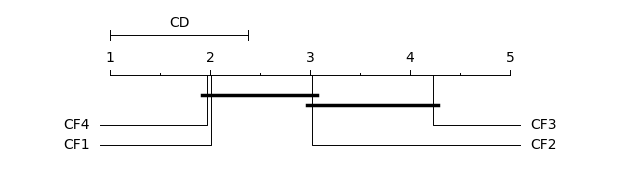

In [9]:
names = ['CF1', 'CF2', 'CF3', 'CF4']
avg_ranks = [2.0123, 3.0234, 4.23312, 1.9677]

cd = compute_CD(avg_ranks, 10, test='bonferroni-dunn')
graph_ranks(avranks=avg_ranks, names=names, cd=cd)